# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Download Dataset**

In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [ ]:
data_path = 'timeline_diagnosed.csv'
# !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

## **Import Packages**

In [ ]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [ ]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


## **Setup Hyper-parameters**

In [ ]:
# data selection
seq_length = 7  # X(seq_length) + Y(1)

start_date = "2022-03-10"
end_date   = "2022-06-01"
delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1 - seq_length
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")

city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
# city_codes = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN"]

# model parameters
num_epochs = 12000
early_stop = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
os.makedirs('models', exist_ok=True)
save_path = "models/model-{}.pth"

# others
seed = 20220605

77


## **Check Raw Data**

In [ ]:
dataset = pd.read_csv(data_path)
print(dataset)

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19683  TTT  2022-06-01    879            15445
19684  PEN  2022-06-01    216             3277
19685  KIN  2022-06-01    145             2582
19686  LIE  2022-06-01     25              665
19687   TW  2022-06-01  76943          2184454

[19688 rows x 4 columns]


In [ ]:
def get_city_data(dataset, city):
    mask = ((dataset["city"] == city) & (dataset["date"] >= start_date) & (dataset["date"] <= end_date))
    city_dataset = dataset[mask]["count"].values.reshape(-1, 1)
    # print(city_dataset)

    # plt.plot(city_dataset, label = 'COVID-19 New Cases')
    # plt.show()
    return city_dataset

## **Preprocessing**

In [ ]:
def data_preprocess(city_dataset):
    def sliding_windows(data, seq_length):
        x = []
        y = []

        for i in range(data_size):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    sc = MinMaxScaler()
    city_data = sc.fit_transform(city_dataset)
    x, y = sliding_windows(city_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    train_indices = [i for i in range(train_size) if i%10 != 7]
    val_indices = [i for i in range(train_size) if i%10 == 7]

    trainX = Variable(torch.Tensor(np.array(x[train_indices])))
    trainY = Variable(torch.Tensor(np.array(y[train_indices])))

    valX = Variable(torch.Tensor(np.array(x[val_indices])))
    valY = Variable(torch.Tensor(np.array(y[val_indices])))

    testX = Variable(torch.Tensor(np.array(x[train_size: len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size: len(y)])))

    return sc, dataX, dataY, trainX, trainY, valX, valY, testX, testY

## **Model**
LSTM + fully connected layer

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

# **Train/Test**

## **Training**

In [ ]:
def train(city, model, trainX, trainY, valX, valY):
    min_loss = np.infty
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, valX, valY)
        if val_loss < min_loss:
            min_loss = val_loss
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path.format(city))
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, loss_record

## **Validation**

In [ ]:
def val(model, valX, valY):
    model.eval()
    _valX, _valY = valX.to(device), valY.to(device)
    with torch.no_grad():
        pred = model(_valX)
        loss = criterion(pred, _valY)
    total_loss = loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [ ]:
loss_record = {}

for city in city_codes:
    same_seeds(seed)
    print(f"===== {city} =====")
    city_dataset = get_city_data(dataset, city)
    _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(city_dataset)
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    city_min_loss, city_loss_record = train(city, lstm, trainX, trainY, valX, valY)
    print(f"{city}: min_loss = {city_min_loss}")
    loss_record[city] = city_loss_record
    del lstm

===== KEE =====
Epoch: 100, loss: 0.00633, 0.00220
Epoch: 200, loss: 0.00579, 0.00146
Epoch: 300, loss: 0.00546, 0.00158
Epoch: 400, loss: 0.00521, 0.00193
Epoch: 500, loss: 0.00501, 0.00242
Epoch: 600, loss: 0.00489, 0.00293
Epoch: 700, loss: 0.00484, 0.00336
Epoch: 800, loss: 0.00482, 0.00363
Epoch: 900, loss: 0.00481, 0.00378
Epoch: 1000, loss: 0.00481, 0.00384
Epoch: 1100, loss: 0.00481, 0.00387
Epoch: 1200, loss: 0.00480, 0.00387
Epoch: 1300, loss: 0.00480, 0.00388
Epoch: 1400, loss: 0.00480, 0.00388
Epoch: 1500, loss: 0.00479, 0.00389
Epoch: 1600, loss: 0.00479, 0.00390
Epoch: 1700, loss: 0.00479, 0.00391
Epoch: 1800, loss: 0.00478, 0.00392
Epoch: 1900, loss: 0.00478, 0.00393
Epoch: 2000, loss: 0.00477, 0.00393
Epoch: 2100, loss: 0.00476, 0.00394
Epoch: 2200, loss: 0.00476, 0.00395
Epoch: 2300, loss: 0.00475, 0.00397
Epoch: 2400, loss: 0.00473, 0.00400
Epoch: 2500, loss: 0.00471, 0.00406
Epoch: 2600, loss: 0.00469, 0.00419
Epoch: 2700, loss: 0.00464, 0.00444
Epoch: 2800, loss: 0.

## **Training and Validation Loss**

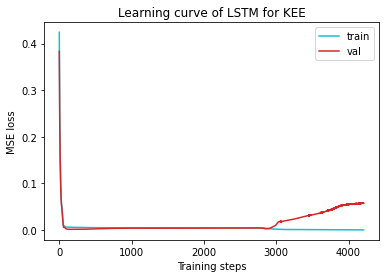

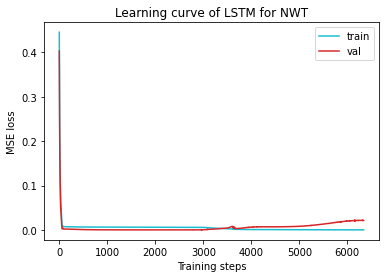

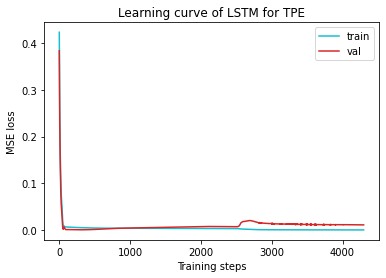

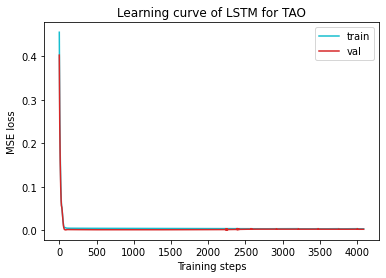

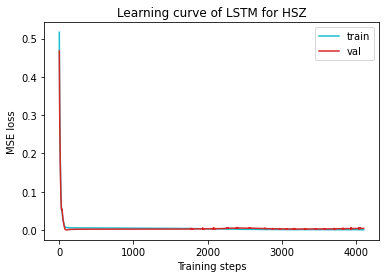

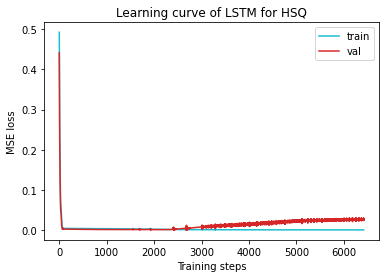

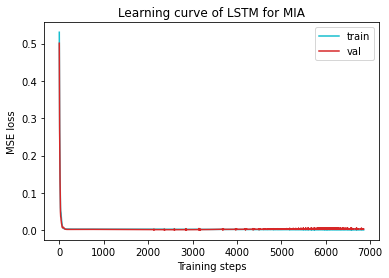

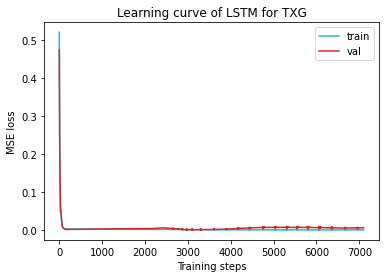

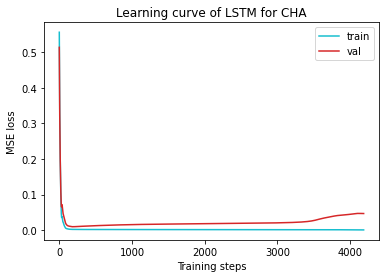

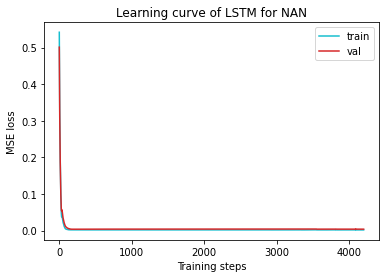

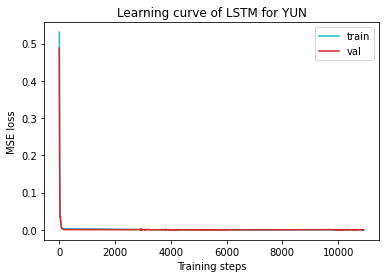

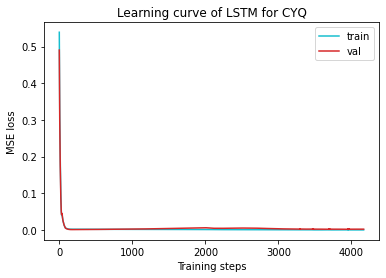

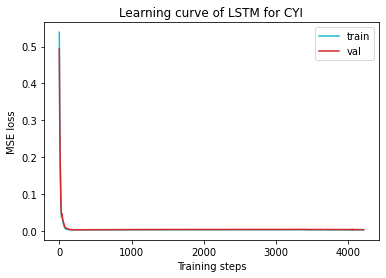

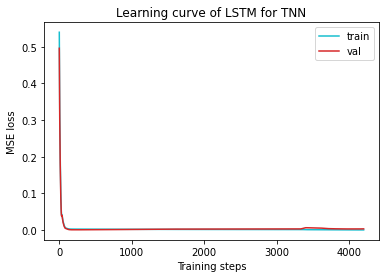

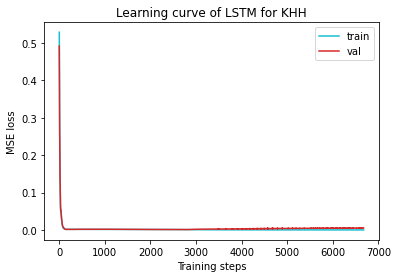

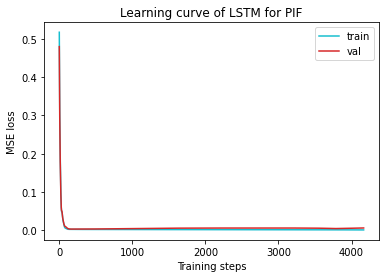

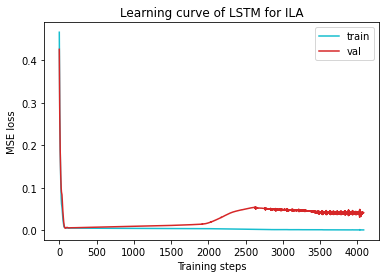

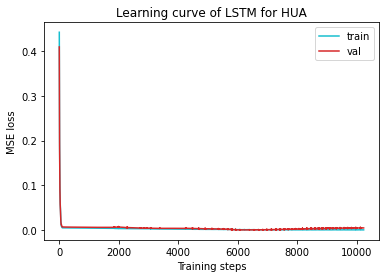

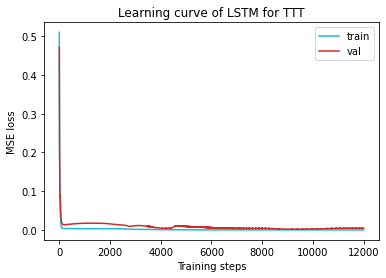

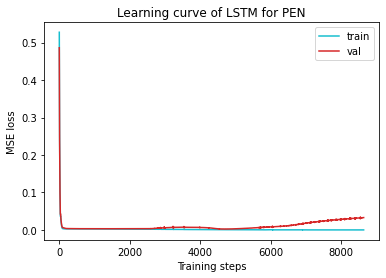

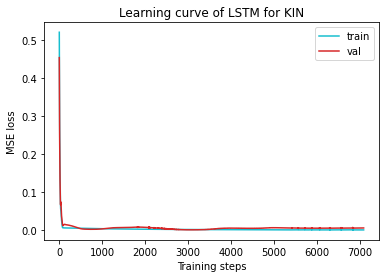

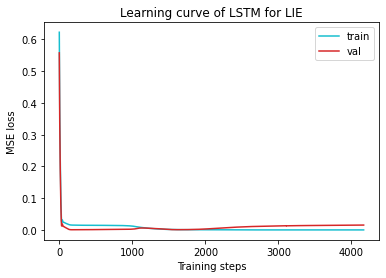

In [ ]:
for city in city_codes:
    total_steps = len(loss_record[city]['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[city]['train']) // len(loss_record[city]['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[city]['train'], c='tab:cyan', label='train')
    plt.plot(x_2, loss_record[city]['val'], c='tab:red', label='val')
    plt.xlabel("Training steps")
    plt.ylabel("MSE loss")
    plt.title(f"Learning curve of LSTM for {city}")
    plt.legend()
    plt.show()

## **Testing**

Define plotting function.

In [ ]:
def plot_predict(city, data_type, pred, real, start_date):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

Test for each city and plot it.

In [ ]:
def test(city, model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)

    return test_predict.detach().cpu(), loss.item()

real & predicted test loss: 0.04967088712146506


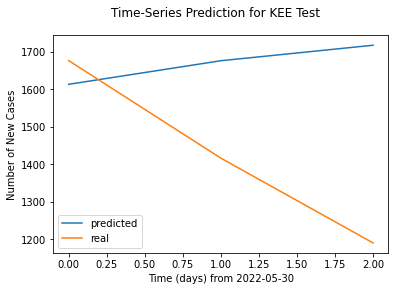

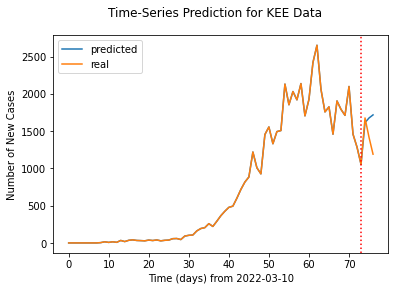

real & predicted test loss: 0.08340902972850017


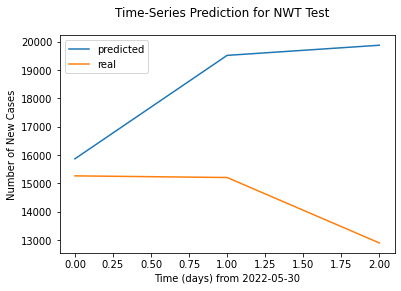

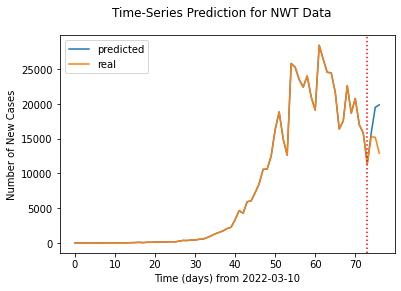

real & predicted test loss: 0.039203991764225066


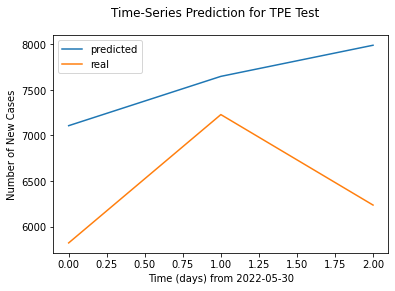

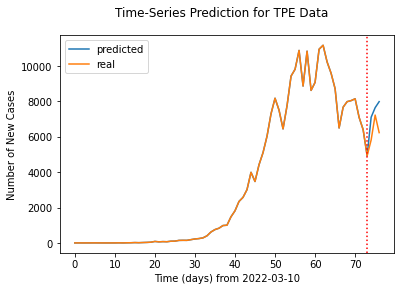

real & predicted test loss: 0.034139592689825804


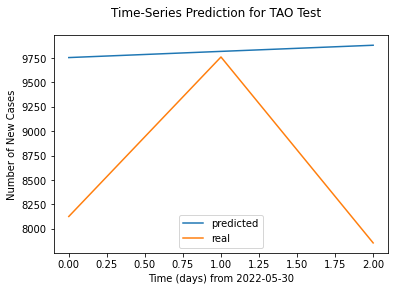

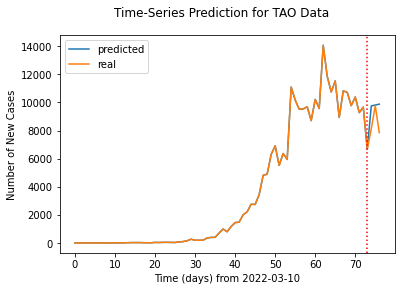

real & predicted test loss: 0.05938440961199376


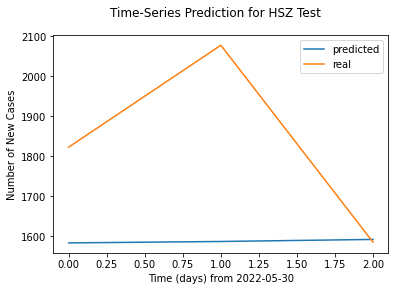

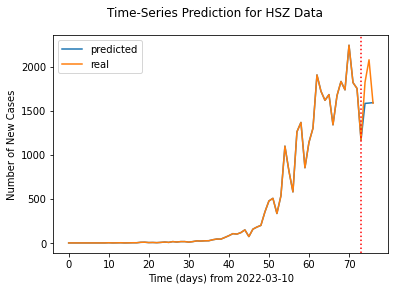

real & predicted test loss: 0.01509492821060121


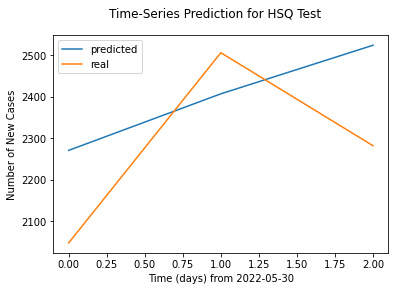

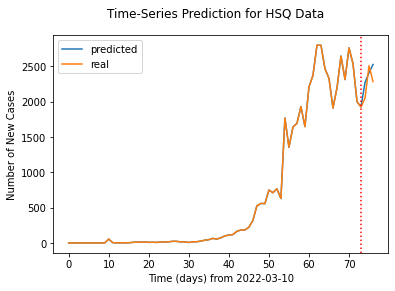

real & predicted test loss: 0.017154163957457058


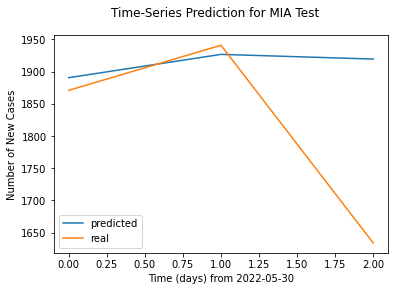

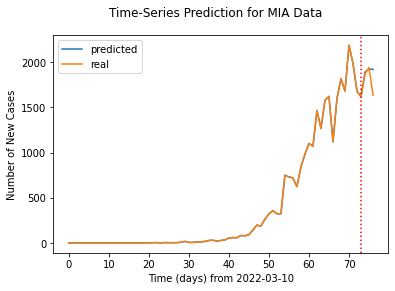

real & predicted test loss: 0.3943573236465454


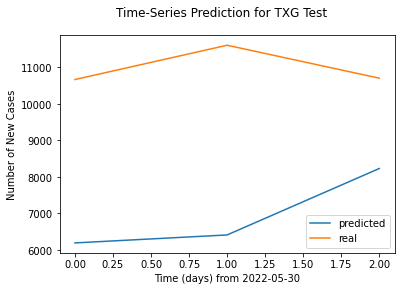

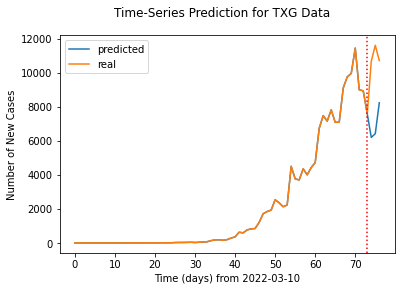

real & predicted test loss: 0.23959968239068985


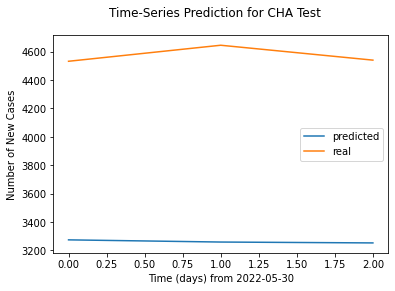

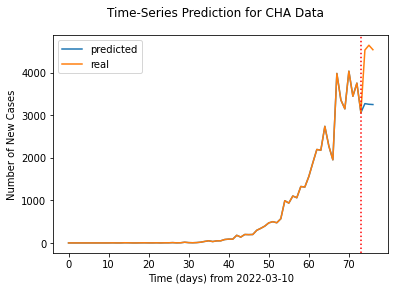

real & predicted test loss: 0.20827657356858253


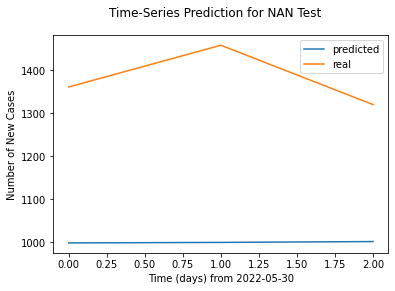

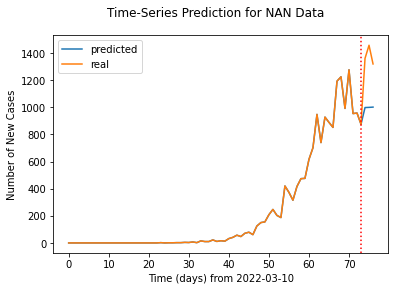

real & predicted test loss: 0.17464445810765028


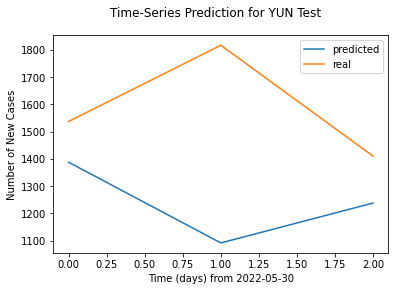

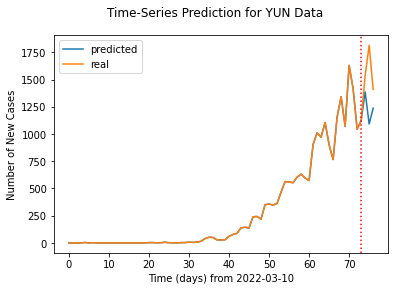

real & predicted test loss: 0.18252098187804222


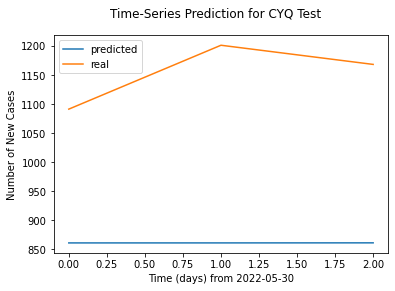

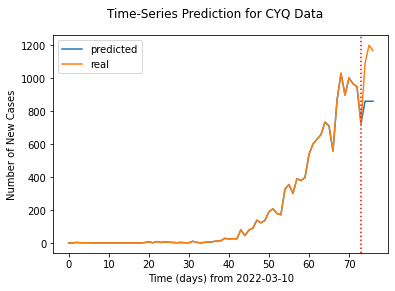

real & predicted test loss: 0.2708544470369816


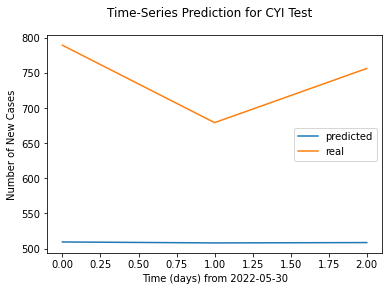

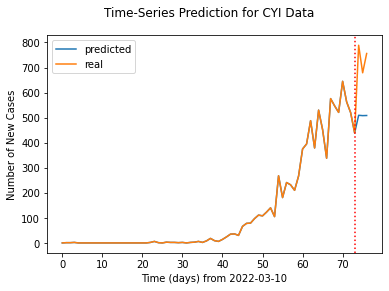

real & predicted test loss: 0.09608642337843776


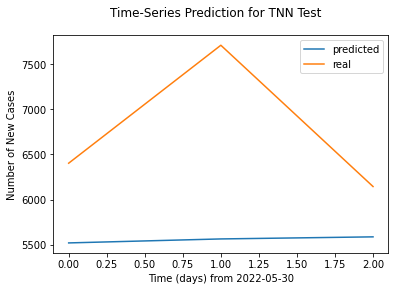

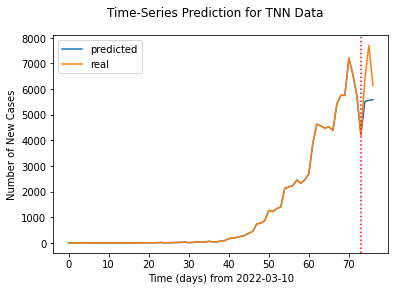

real & predicted test loss: 0.020864954916760325


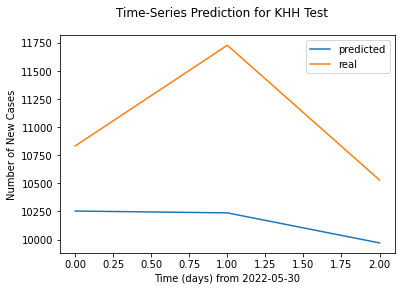

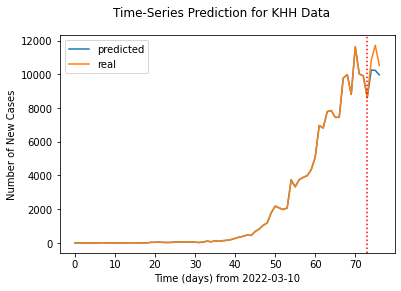

real & predicted test loss: 0.0976497270166874


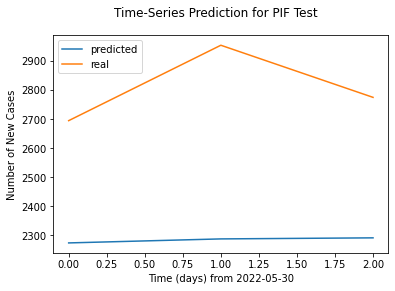

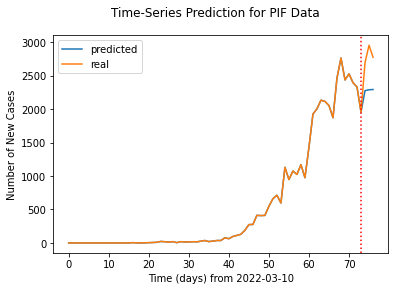

real & predicted test loss: 0.014508682594168931


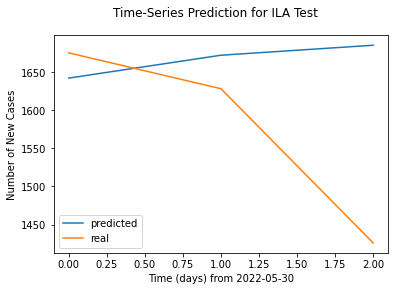

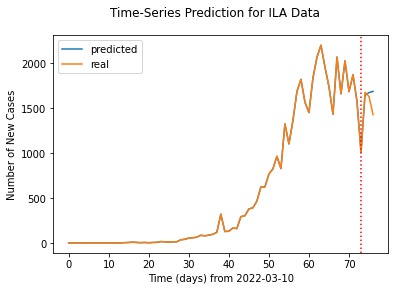

real & predicted test loss: 0.025439002085477114


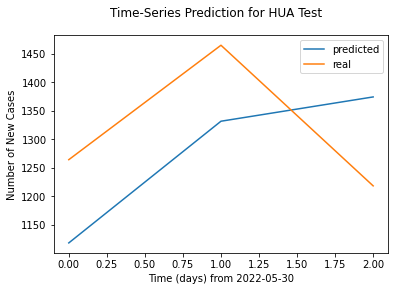

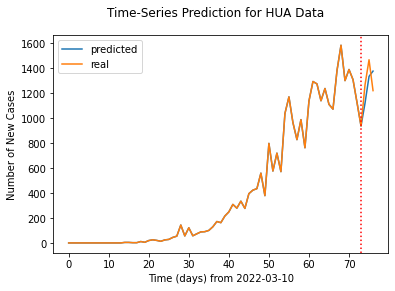

real & predicted test loss: 0.1285077049396932


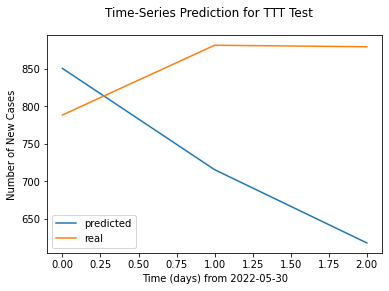

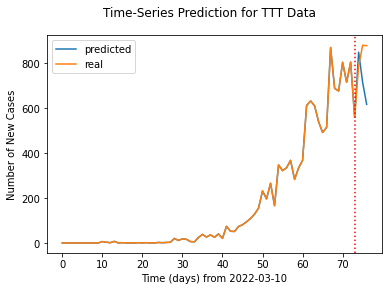

real & predicted test loss: 0.14174092188477516


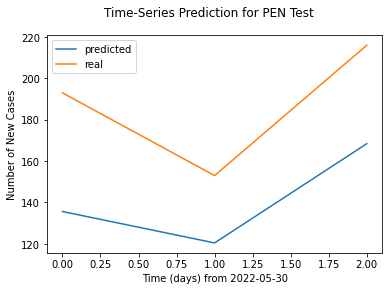

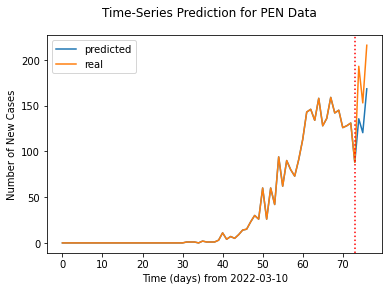

real & predicted test loss: 0.14983093320188345


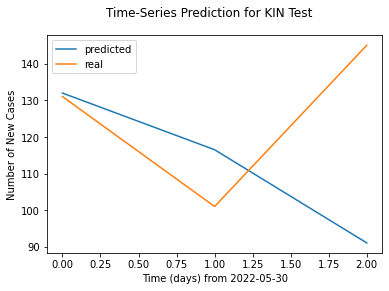

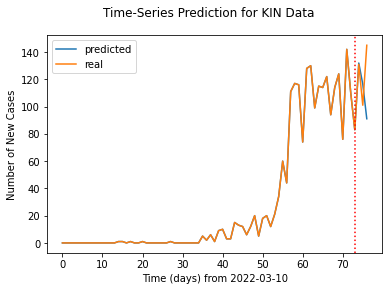

real & predicted test loss: 0.11180887604132295


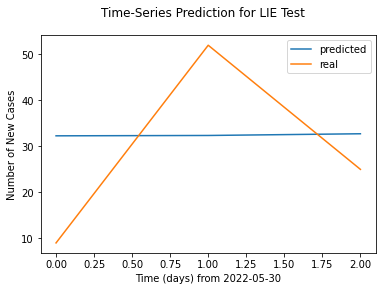

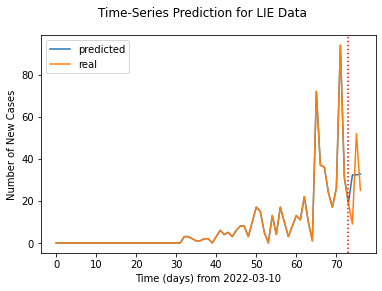

In [ ]:
for city in city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_dataset = get_city_data(dataset, city)
    sc, dataX, dataY, _, _, _, _, testX, testY = data_preprocess(city_dataset)
    
    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_loss = 0
    total_test_predict = []
    for i in range(testY.size(0)):
        test_predict, loss = test(city, lstm, _testX, testY[[i]])
        total_loss += loss
        total_test_predict.append(test_predict)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)

    total_test_predict = sc.inverse_transform(total_test_predict.data.numpy())
    _testY = sc.inverse_transform(testY.data.numpy())
    print(f"real & predicted test loss: {total_loss}")
    plot_predict(city, "Test", total_test_predict, _testY, test_start_date)

    dataY = sc.inverse_transform(dataY.data.numpy())
    _dataY = np.copy(dataY)
    for i in range(testY.size(0)):
        _dataY[-test_size+i][0] = total_test_predict[i][0]
    # print(_dataY)
    plot_predict(city, "Data", _dataY, dataY, start_date)


    # # test set: real data -> predicted data
    # test_predict, loss = test(city, lstm, testX, testY)
    # test_predict = sc.inverse_transform(test_predict.data.numpy())
    # testY = sc.inverse_transform(testY.data.numpy())
    # print(f"test loss: {loss}")
    # plot_predict(city, "Test", test_predict, testY, test_start_date)

    # # train + validation + test set: real data -> predicted data
    # data_predict, loss = test(city, lstm, dataX, dataY)
    # data_predict = sc.inverse_transform(data_predict.data.numpy())
    # dataY = sc.inverse_transform(dataY.data.numpy())
    # print(f"test loss: {loss}")
    # plot_predict(city, "Data", data_predict, dataY, train_start_date)

    del lstm